In [2]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

In [3]:
import numpy as np
import pandas as pd

# list of columns that we want to use for out training and testing of our models
cols = ['Pclass','Sex','AgeGroup','SibSp','Parch','Embarked','Survived',
        'cabin_adv','cabin_multiple','numeric_ticket', 'name_title']

train_data_ratio = 0.8
valid_data_ratio = 0.1
test_data_ratio = 0.1

def create_age_groups(df):
    """
    Creates a new column on the given data frame by grouping age as per the following order:
        [ 0 -  2]  => Infant
        [ 2 -  4]  => Toddler
        [ 4 - 13]  => Kid
        [13 - 20]  => Teen
        [20 - --]  => Adult
        [  NAN  ]  => Unknown
    
    Args:
        df: pandas DataFrame containing all the data frame
    
    Returns:
        new pandas DataFrame with a new column ("AgeGroup") added to it
    """
    bins = [0,2,4,13,20,110]
    labels = ['Infant','Toddler','Kid','Teen','Adult']

    age_groups = pd.cut(df['Age'], bins=bins, labels=labels, right=False, retbins=True)[0]
    df['AgeGroup'] = age_groups
    df['AgeGroup'].replace(np.nan, 'Unknown', inplace=True)
    return df

def add_name_title(df):
    """
    Exracts name title from the name column and adds it as a new column ("NameTitle")
    
    Args:
        df: pandas DataFrame containing all the data frame
    
    Returns:
        new pandas DataFrame with a new column ("NameTitle") added to it
    """
    df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    return df


def load_data(filepath):
    """
    Loads the titanic data from the provided filepath and does some pre-processing
    to prepare data for use in our model training/testing
    Args:
        filepath: str of file path to be loaded
    
    Returns:
        a list of tuples with data separated in train, valid, test where each tuple has x,y data,
        i.e. train_x, train_y = list[0]
             valid_x, valid_y = list[1]
             test_x, test_y = list[2]
    """
    df = pd.read_csv(filepath, index_col="PassengerId")

    # Add age group to our data
    df = create_age_groups(df)

    # extract name title
    df = add_name_title(df)

    #drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
    df.dropna(subset=['Embarked'], inplace = True)

    # create categorical variables
    df['cabin_multiple'] = df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
    df['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
    df['numeric_ticket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
    df.Pclass = df.Pclass.astype(str)

    # create dummy variables from categories
    all_dummies = pd.get_dummies(df[cols])

    # Randomize the dataset
    data_randomized = all_dummies.sample(frac=1, random_state=1)

    # Calculate index to split data into train/validate/test
    train_len = round(len(data_randomized) * train_data_ratio)
    valid_len = round(len(data_randomized) * valid_data_ratio)
    valid_end_idx = train_len + valid_len
    

    # Split into training and test sets
    train = data_randomized[:train_len]
    valid = data_randomized[train_len:valid_end_idx]
    test = data_randomized[valid_end_idx:]

    # extract label column for each set
    train_y = train.Survived
    train_x = train.drop(['Survived'], axis = 1)

    valid_y = valid.Survived
    valid_x = valid.drop(['Survived'], axis = 1)

    test_y = test.Survived
    test_x = test.drop(['Survived'], axis = 1)

    return [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]

In [4]:
filename = "train.csv"

In [5]:
data = load_data(filename)

train_x, train_y = data[0]
test_x, test_y = data[2]

In [91]:
print(len(train_x))

711


In [6]:
def train_random_forest_classifier():
    clf = RandomForestClassifier(max_depth=25, min_samples_split=2)
    clf.fit(train_x, train_y)
    clf.predict(test_x)
    print(clf.score(train_x, train_y))
    print(clf.score(test_x, test_y))

In [7]:
train_random_forest_classifier()

0.9184247538677919
0.7640449438202247


In [8]:
from sklearn.naive_bayes import GaussianNB
def GaussianNB_model():
    clf = GaussianNB()
    clf.fit(train_x,train_y)
    clf.predict(test_x)
    print(clf.score(train_x,train_y))
    print(clf.score(test_x, test_y))

In [9]:
GaussianNB_model()

0.7313642756680732
0.6067415730337079


In [10]:
from sklearn.linear_model import LogisticRegression
def logistic_regression_model():
    clf = LogisticRegression(max_iter=10000,solver='saga')
    clf.fit(train_x,train_y)
    clf.predict(test_x)
    print(clf.score(train_x,train_y))
    print(clf.score(test_x, test_y))

In [11]:
logistic_regression_model()

0.8466947960618847
0.797752808988764


In [12]:
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def svc_model():
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', max_iter=10000,kernel='linear'))
    clf.fit(train_x,train_y)
    print(clf.score(train_x,train_y))
    clf.predict(test_x)
    print(clf.score(test_x, test_y))

In [13]:
svc_model()

0.8438818565400844
0.7865168539325843


In [105]:
from keras.regularizers import l2
def train_keras_model():
    model = Sequential()
    model.add(Dense(24, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu',kernel_regularizer=l2(0.2), bias_regularizer=l2(0.01)))
    model.add(Dense(1, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.001)))
    # compile the keras model
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=1000, batch_size=711)
    # evaluate the keras model
    _, accuracy = model.evaluate(test_x, test_y)
    print('Accuracy: %.2f' % (accuracy*100))
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()

In [106]:
#since the Random forest is the same as bagging, we going to jump into Voting 76.40

Epoch 1/1000
1/1 [==============================] - 1s 990ms/step - loss: 2.6356 - accuracy: 0.6301 - val_loss: 2.6682 - val_accuracy: 0.5955
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.6140 - accuracy: 0.6301 - val_loss: 2.6488 - val_accuracy: 0.5955
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.5930 - accuracy: 0.6315 - val_loss: 2.6294 - val_accuracy: 0.5955
Epoch 4/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.5728 - accuracy: 0.6371 - val_loss: 2.6103 - val_accuracy: 0.6067
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.5530 - accuracy: 0.6428 - val_loss: 2.5913 - val_accuracy: 0.6180
Epoch 6/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.5332 - accuracy: 0.6540 - val_loss: 2.5724 - val_accuracy: 0.6292
Epoch 7/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.5136 - accuracy: 0.6582 - val_loss: 2.5542 - val_accuracy: 0.6292
Epoch 8/1000

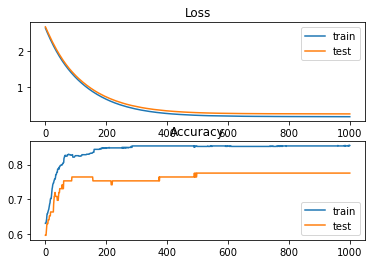

0.797752808988764


F:\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:233: FutureWarning: Using 'None' to drop an estimator from the ensemble is deprecated in 0.22 and support will be dropped in 0.24. Use the string 'drop' instead.
  warnings.warn(


In [109]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(max_iter=10000,solver='saga')
clf2 = train_keras_model()
clf3 = make_pipeline(StandardScaler(), SVC(gamma='auto', max_iter=10000,kernel='linear'))
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
eclf = eclf.fit(train_x,train_y)
eclf.predict(test_x)
print(eclf.score(test_x,test_y))

In [ ]:
0.7752808988764045